In [1]:
import re
from struct import unpack, pack
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import normalize
import binascii
from pathlib import Path
import time
import csv
from utils import *


def parsing_nmea(nmea_file, export_dir='.'):
    # NMEA parameters
    nmea_args = {
        'time':[],
        'latitude':[], 
        'longitude':[], 
        'enu_x':[], 
        'enu_y':[], 
        'speed':[], 
        'course':[], 
        'altitude':[], 
        'sat_num':[], 
        'hdop':[]
    }
    df_nmea = pd.read_csv(nmea_file,header=None)
    df_nmea = df_nmea.drop_duplicates(subset=df_nmea.columns[1])
    df_dgps = pd.DataFrame.from_dict(nmea_args)

    t = df_nmea.iloc[:,1].to_numpy()*100
    df_nmea.iloc[:,1] = 360000*((t//1000000)) + 6000*((t//10000)%100) + t%10000;
    col_time = np.arange(df_nmea.iloc[0,1]*0.1, df_nmea.iloc[-1,1]*0.1)*10
    df_dgps['time'] = col_time
    
    for i in range(len(df_dgps)):
        row = df_dgps.iloc[i]
        t = row['time']
        target = df_nmea[df_nmea.iloc[:,1]==t]
        if(len(target) > 0):
            if(target.iloc[0,0] == "$GNRMC"):
                row.loc[['latitude','longitude','speed','course']]= target.iloc[0,[3,5,7,8]].to_numpy()
            elif(target.iloc[0,0] == "$GNGGA"):
                row[['latitude','longitude']]= target.iloc[0,[2,4]]
            df_dgps.iloc[i] = row

    df_dgps['latitude'] = NMEAtoDeg(df_dgps['latitude'].to_numpy())        
    df_dgps['longitude'] = NMEAtoDeg(df_dgps['longitude'].to_numpy())       
    
    df_dgps[['latitude','longitude','speed']] = df_dgps[['latitude','longitude','speed']].interpolate(method='polynomial', order=2, limit_direction='both')
    df_dgps['speed'] = df_dgps['speed'].to_numpy()*0.514444
    
    x, y, _ = geodetic_to_enu(df_dgps['latitude'], df_dgps['longitude'], np.zeros(df_dgps['latitude'].shape), lat0, lon0, h0)
    df_dgps['enu_x'] = x
    df_dgps['enu_y'] = y
  #  df_dgps[['enu_x','enu_y']] = df_dgps[['enu_x','enu_y']].interpolate(method='polynomial', order=2, limit_direction='both')
       
    return df_dgps



def show_gps_comp(df_epts, df_dgps, idx_start=1, idx_end=None, enu_format=0):
    
    dx, dy, _ = geodetic_to_enu(lat0+0.0001,lon0+0.0001,0, lat0, lon0, h0)
    background_ratio = dy/dx
    pos_range = [129.3186, 129.3202, 36.0124, 36.0140] # POSTECH Field
    
    epts_time = df_epts[['time']][idx_start:idx_end].to_numpy()
    epts_lat  = df_epts[['latitude']][idx_start:idx_end].to_numpy()
    epts_lon  = df_epts[['longitude']][idx_start:idx_end].to_numpy()
    epts_enu_x = df_epts[['enu_x']][idx_start:idx_end].to_numpy()
    epts_enu_y = df_epts[['enu_y']][idx_start:idx_end].to_numpy()
    
    dgps_time = df_dgps[['time']][idx_start:idx_end].to_numpy()
    dgps_lat  = df_dgps[['latitude']][idx_start:idx_end].to_numpy()
    dgps_lon  = df_dgps[['longitude']][idx_start:idx_end].to_numpy()
    dgps_enu_x = df_dgps[['enu_x']][idx_start:idx_end].to_numpy()
    dgps_enu_y = df_dgps[['enu_y']][idx_start:idx_end].to_numpy()
    
    if(enu_format):
        epts_lat = epts_enu_y
        epts_lon = epts_enu_x
        dgps_lat = dgps_enu_y
        dgps_lon = dgps_enu_x
    else:
        #plt.axis(pos_range)
        img = plt.imread("background2.png")
        plt.imshow(img, extent=pos_range)

    #for idx, xy in enumerate(zip(lon,lat)):
    #    if(idx % 10 == 0):
            #plt.annotate('{}'.format(int(df.index(idx))), xy=xy, textcoords='data')
    #       plt.annotate('{},{:.3f},{:.3f}'.format(idx, xy[0], xy[1]), xy=xy, textcoords='data')
    hfont = {'fontname':'Serif'}

    plt.plot(epts_lon,epts_lat,'bo', markersize=10, label='EPTS')
    plt.plot(dgps_lon,dgps_lat,'ro', markersize=10, label='TRUE')
    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
    plt.axes().set_aspect(1.0)
#    plt.axes().set_aspect(background_ratio)
    plt.grid(b=True)
    plt.xlabel('X (m)', fontsize=80, labelpad=10, **hfont)
    plt.ylabel('Y (m)', fontsize=80, labelpad=10, **hfont)
    plt.xticks(fontsize =80)
    plt.yticks(fontsize =80)
    plt.legend(prop={'size': 80}, loc=2)
    plt.show()


4


/workspace/shared/kfa_new/utils.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(background_ratio)


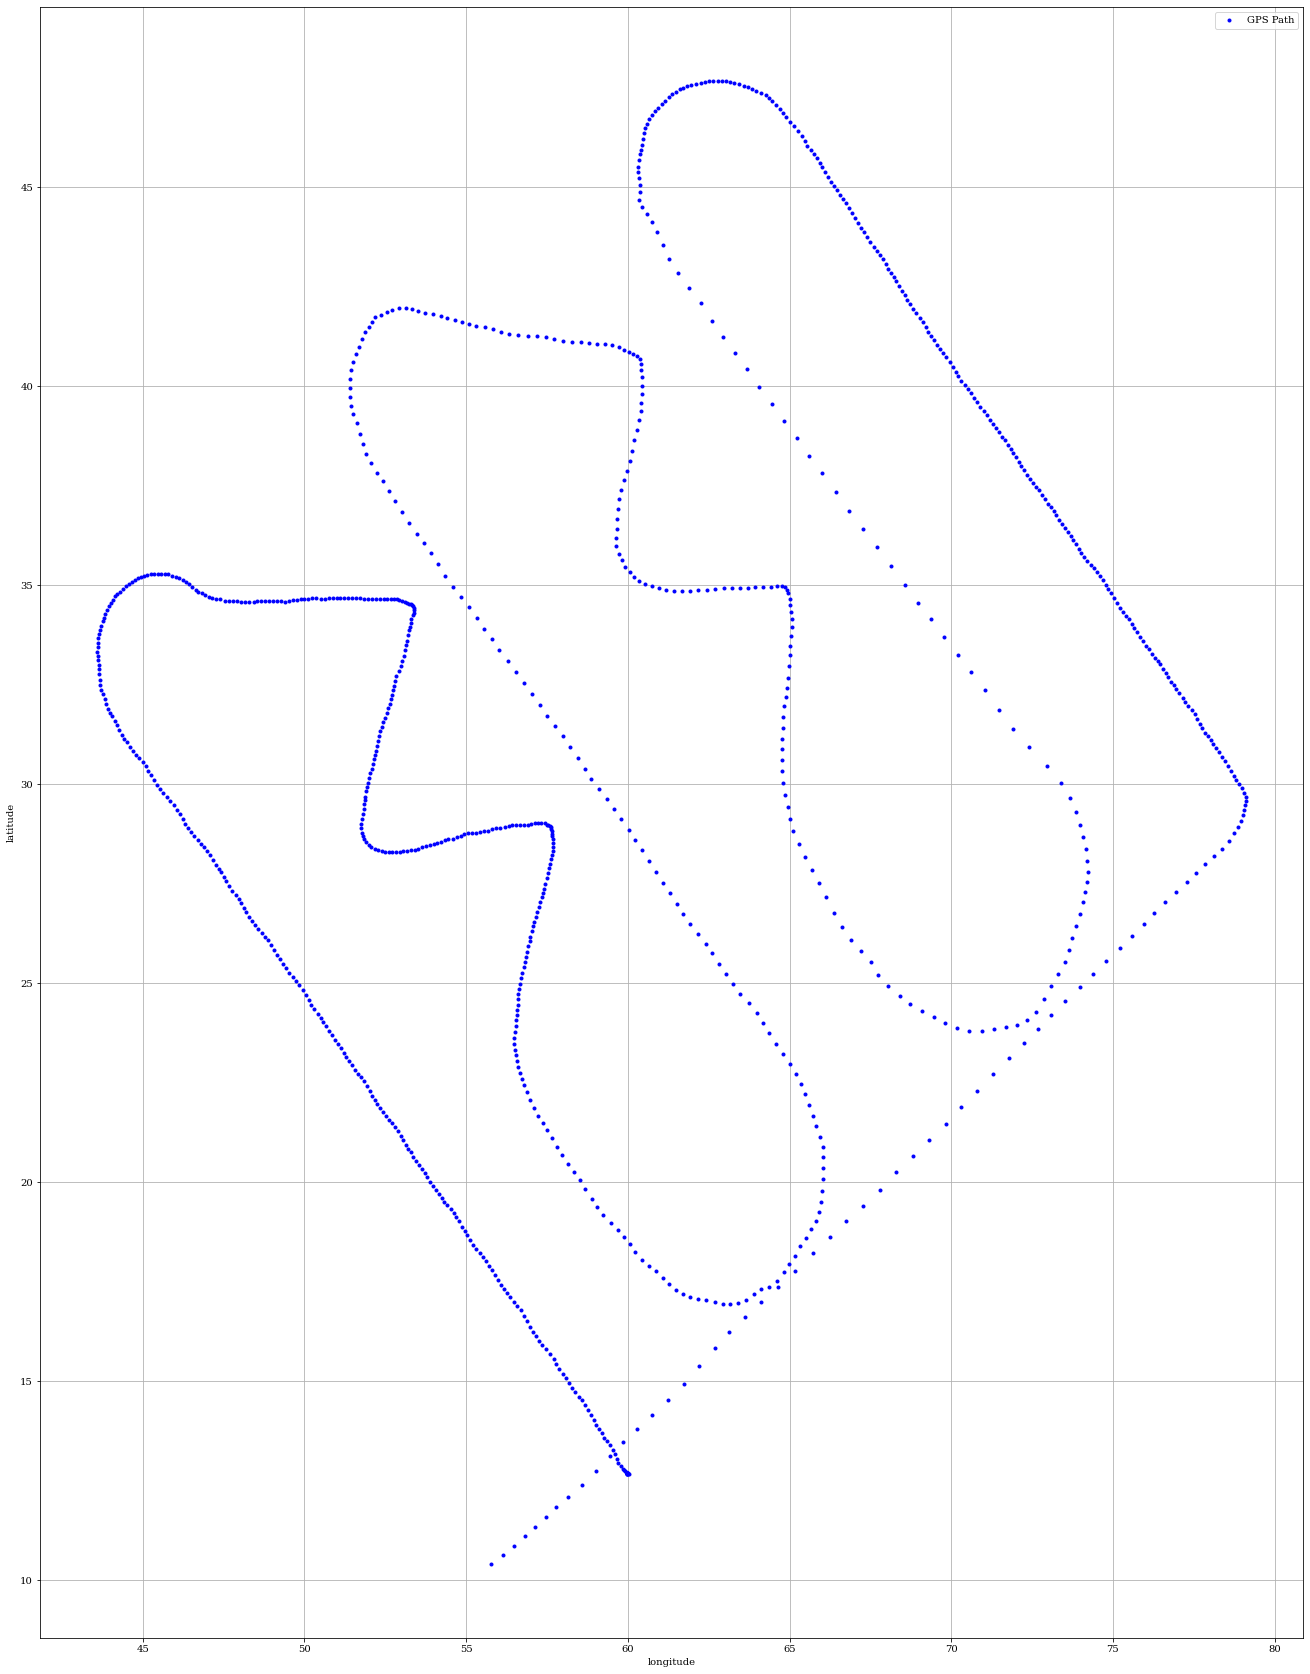

5


/workspace/shared/kfa_new/utils.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(background_ratio)


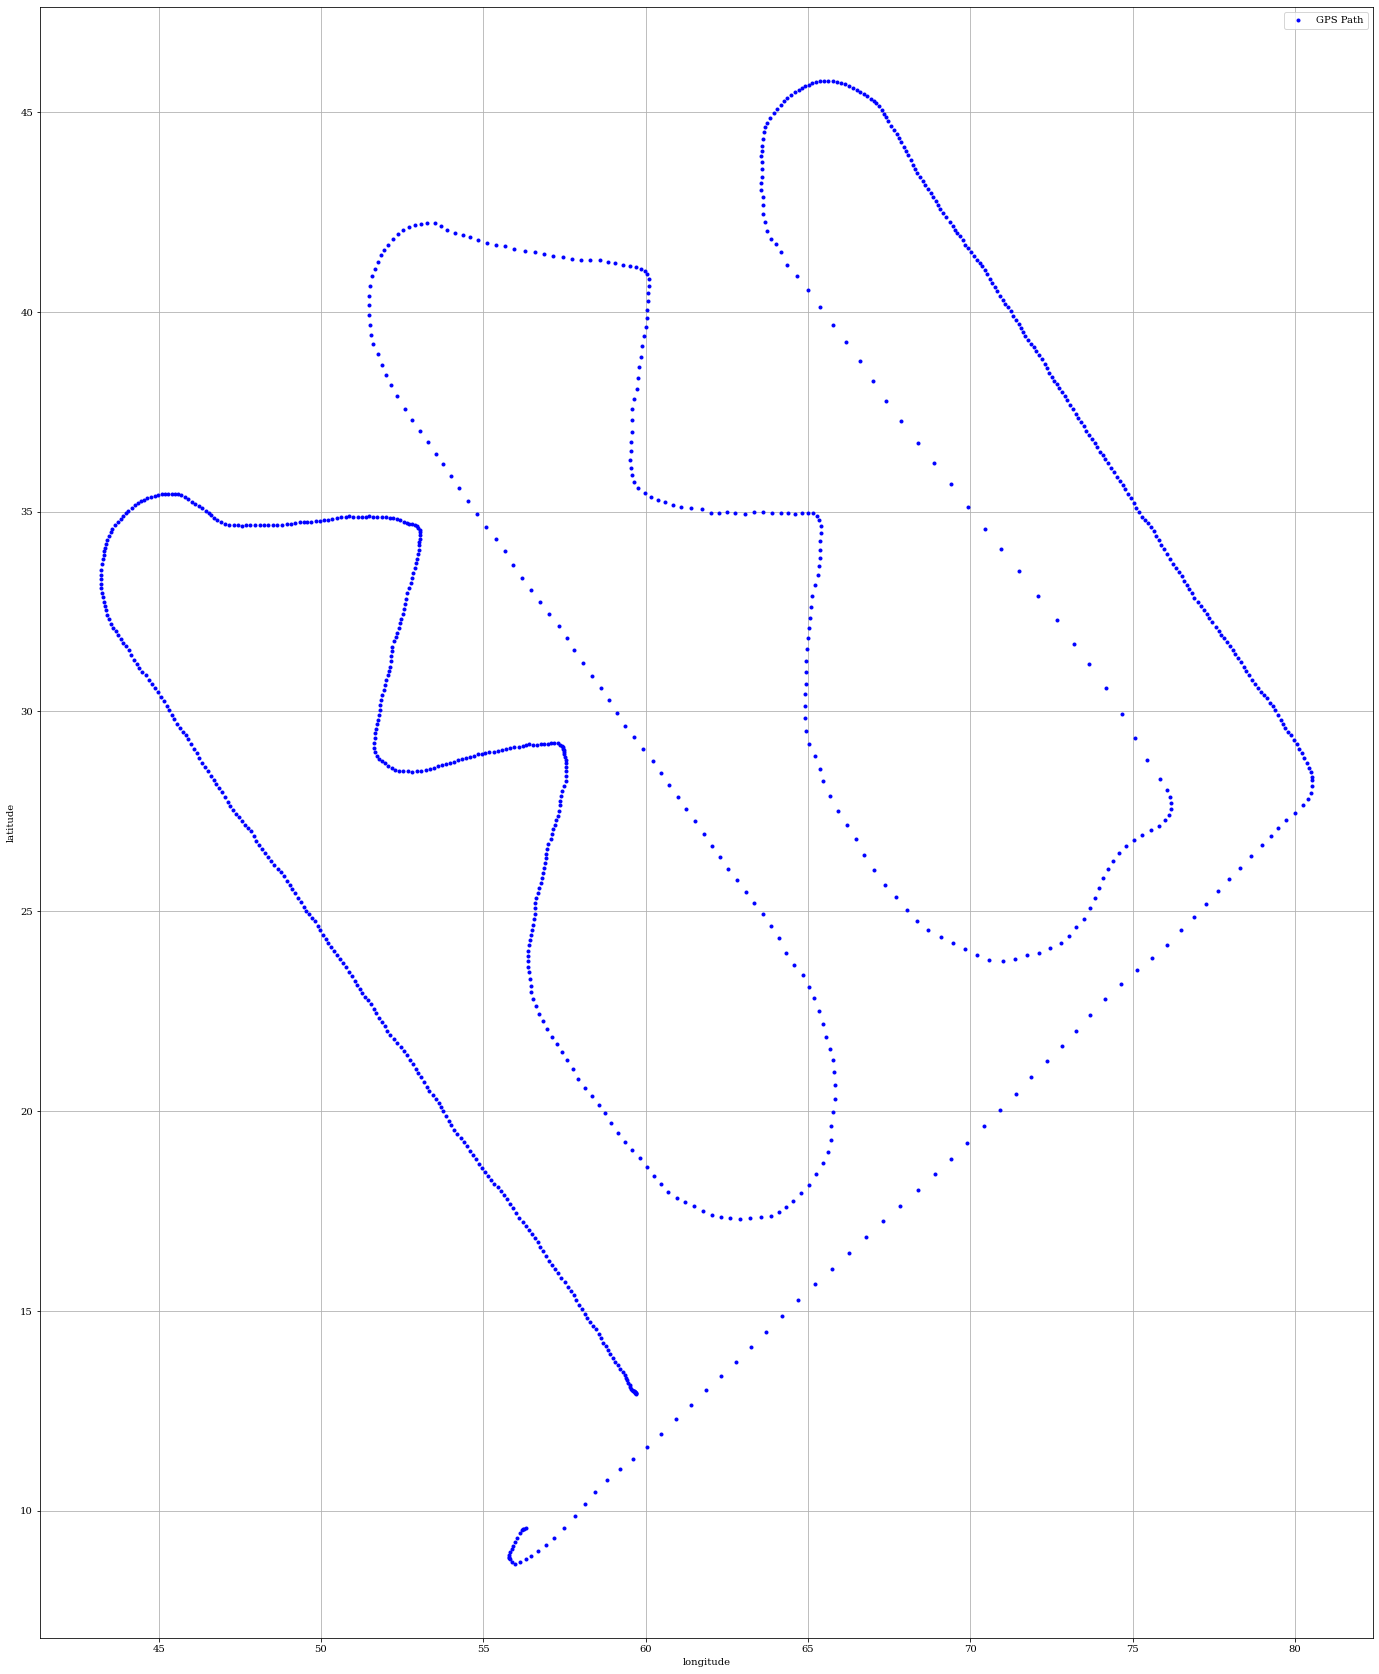

In [6]:
set_pyplot_options(figsize=30, font="serif")
dir_data = Path('./data/20200908/')
dfs_dgps = []

for i in [4,5]:
    print(i)
    df_dgps = parsing_nmea(dir_data/(str(i)+'.TXT'))
    dfs_dgps.append(df_dgps)
    show_gps(df_dgps, enu_format=1)
    #print(df_dgps.head(1))
for i, df in enumerate(dfs_dgps[:]):
    df.to_csv(dir_data / Path('datasets') / f'circuit_dgps_{i}.csv', index=False)